In [2]:
from transformers import ViTImageProcessor, ViTForImageClassification
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import pickle

external_path=''

In [3]:
class MLP(torch.nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super().__init__()
        self.layer=torch.nn.Linear(in_dimension,out_dimension)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer(x)

In [6]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('aaraki/vit-base-patch16-224-in21k-finetuned-cifar10')

concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

mlp=MLP(768,10)

with torch.no_grad():
    mlp.layer.weight=torch.nn.Parameter(model.classifier.weight)
    mlp.layer.bias=torch.nn.Parameter(model.classifier.bias)

In [18]:
def intermediate_layer_accuracy(concept,layer,classifier):
    for k in range(1,11):
        if k==1:
            concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt')
        else:
            concept_activations=torch.cat([concept_activations,torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt')])
    
    acc=0
    count=0
    for k in range(concept_activations.shape[0]):
        prediction=concepts[classifier(concept_activations[k,:]).argmax().item()]
        if prediction==concept:
            acc+=1
        count+=1
    return acc/count

In [14]:
if os.path.exists(f'{external_path}\\intermediate_layer_accuracies'):
    intermediate_layer_accuracies_file=open(f'{external_path}\\intermediate_layer_accuracies','rb')
    intermediate_layer_accuracies=pickle.load(intermediate_layer_accuracies_file)
    intermediate_layer_accuracies_file.close()
else:
    intermediate_layer_accuracies={concept:{} for concept in concepts}

pbar=tqdm(range(13))
for layer in pbar:
    for concept in concepts:
        accuracy=intermediate_layer_accuracy(concept,layer,mlp)
        intermediate_layer_accuracies[concept][layer]=accuracy
        pbar.set_description(f'Layer {layer}: {concept} accuracy={accuracy:.4f}')

intermediate_layer_accuracies_file=open(f'{external_path}\\concept_formation\\stock_classifier\\intermediate_layer_accuracies','wb')
pickle.dump(intermediate_layer_accuracies,intermediate_layer_accuracies_file)
intermediate_layer_accuracies_file.close()

Layer 12: truck accuracy=1.0000: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]     


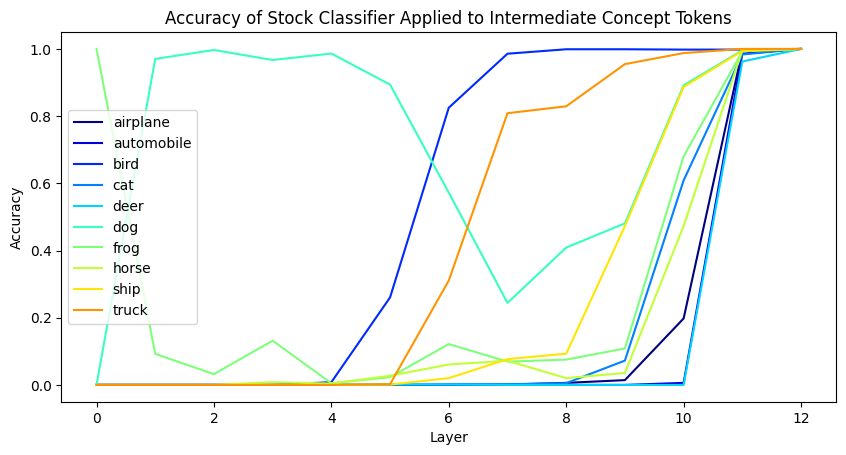

In [27]:
intermediate_layer_accuracies_file=open(f'{external_path}\\concept_formation\\stock_classifier\\intermediate_layer_accuracies','rb')
intermediate_layer_accuracies=pickle.load(intermediate_layer_accuracies_file)
intermediate_layer_accuracies_file.close()

fig,axs=plt.subplots(nrows=1,ncols=1)
fig.set_figwidth(10)

colors=plt.cm.jet(np.linspace(0,0.75,len(intermediate_layer_accuracies.keys())))
for n,concept in enumerate(intermediate_layer_accuracies.keys()):
    axs.plot(intermediate_layer_accuracies[concept].keys(),intermediate_layer_accuracies[concept].values(),color=colors[n],label=concept)
axs.set_title('Accuracy of Stock Classifier Applied to Intermediate Concept Tokens')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Layer')
axs.legend()
plt.savefig(f'{external_path}\\concept_formation\\stock_classifier\\accuracy_across_layers_plot.png')
plt.show()

In [13]:
def get_dataset(layer):
    for n,concept in enumerate(concepts):
        num_concept_activations=0
        for k in range(1,11):
            if n==0 and k==1:
                layer_activations=torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt').squeeze(1)
                num_concept_activations+=layer_activations.shape[0]
            else:
                activations=torch.load(f'{external_path}\\concept_token_activations\\{concept}\\layer{layer}_{k}.pt').squeeze(1)
                layer_activations=torch.cat([layer_activations,activations])
                num_concept_activations+=activations.shape[0]
        if n==0:
            labels=torch.zeros(num_concept_activations)
        else:
            labels=torch.cat([labels,n*torch.ones(num_concept_activations)])

    perm=torch.randperm(layer_activations.shape[0])
    layer_activations=layer_activations[perm,:]
    labels=labels[perm]

    return layer_activations.detach(),labels.detach().type(torch.int64)

In [20]:
lr=1e-3
batch_size=64
epochs=100
model_losses={}
pbar=tqdm(range(13))
for layer in pbar:
    layer_activations,labels=get_dataset(layer)
    layer_classifier=MLP(768,10)
    optimizer=torch.optim.Adam(layer_classifier.parameters(),lr=lr)
    criterion=nn.CrossEntropyLoss()
    dataset_size=layer_activations.shape[0]
    for epoch in range(epochs):
        epoch_loss=0
        epoch_cycles=dataset_size//batch_size
        if dataset_size%batch_size!=0:
            epoch_cycles+=1
        for k in range(epoch_cycles):
            if k==epoch_cycles-1:
                epoch_activations=layer_activations[k*batch_size:,:]
                epoch_labels=labels[k*batch_size:]
            else:
                epoch_activations=layer_activations[k*batch_size:(k+1)*batch_size,:]
                epoch_labels=labels[k*batch_size:(k+1)*batch_size]
            optimizer.zero_grad()
            output=layer_classifier(epoch_activations)
            loss=criterion(output,epoch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()*len(epoch_labels)
        epoch_loss/=dataset_size
        pbar.set_description(f'Layer {layer}...training classifier...epoch {epoch+1}/{epochs} loss={epoch_loss:.4f}')
    model_losses[layer]=epoch_loss
    torch.save(layer_classifier.state_dict(),f'{external_path}\\concept_formation\\trained_classifier\\layer{layer}_trained_model.pt')
    layer_classifier.eval()
    layer_accuracies={}
    for concept in concepts:
        layer_accuracies[concept]=intermediate_layer_accuracy(concept,layer,layer_classifier)
        pbar.set_description(f'Layer {layer}...getting accuracies...concept {concept} accuracy={layer_accuracies[concept]:.4f}')
    layer_accuracies_file=open(f'{external_path}\\concept_formation\\trained_classifier\\layer{layer}_accuracies','wb')
    pickle.dump(layer_accuracies,layer_accuracies_file)
    layer_accuracies_file.close()

Layer 12...getting accuracies...concept truck accuracy=1.0000: 100%|██████████| 13/13 [05:00<00:00, 23.14s/it]     


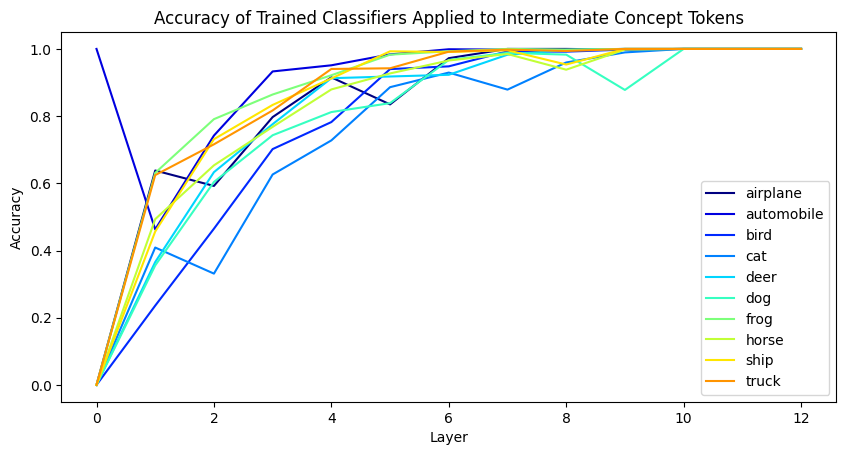

In [26]:
aggregate_accuracies={concept:[] for concept in concepts}
layers=range(13)
for layer in layers:
    layer_accuracies_file=open(f'{external_path}\\concept_formation\\trained_classifier\\layer{layer}_accuracies','rb')
    layer_accuracies=pickle.load(layer_accuracies_file)
    layer_accuracies_file.close()
    for concept,accuracy in layer_accuracies.items():
        
        aggregate_accuracies[concept].append(accuracy)

fig,axs=plt.subplots(nrows=1,ncols=1)
fig.set_figwidth(10)

colors=plt.cm.jet(np.linspace(0,0.75,len(aggregate_accuracies.keys())))
for n,(concept,accuracies) in enumerate(aggregate_accuracies.items()):
    axs.plot(layers,accuracies,color=colors[n],label=concept)
axs.set_title('Accuracy of Trained Classifiers Applied to Intermediate Concept Tokens')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Layer')
axs.legend()
plt.savefig(f'{external_path}\\concept_formation\\trained_classifier\\accuracy_across_layers_plot.png')
plt.show()